# Rough Volatility Neural SDE: Results

This notebook demonstrates the key results of the Rough Volatility Neural SDE framework:

1. **Roughness:** Real vs Synthetic log-volatility paths
2. **Long Memory:** Autocorrelation of absolute returns
3. **Deep Hedging:** PnL comparison (Black-Scholes vs Neural Hedge)


## Setup

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['figure.figsize'] = (12, 5)
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete!")


Setup complete!


In [2]:
# Import our framework modules
from noise.fbm import DaviesHarte
from models.generator import RoughNeuralSDE
from hedging.engine import DeepHedgingAgent, HedgingEnvironment, black_scholes_delta
from data.market_data import get_synthetic_data

print("Modules loaded successfully!")


Modules loaded successfully!


## 1. Real vs Synthetic Log-Volatility Paths

Rough volatility models use fractional Brownian motion (fBM) with Hurst parameter $H < 0.5$
to capture the "roughness" observed in real market volatility.

Key insight: Lower $H$ = rougher paths = more realistic volatility dynamics.


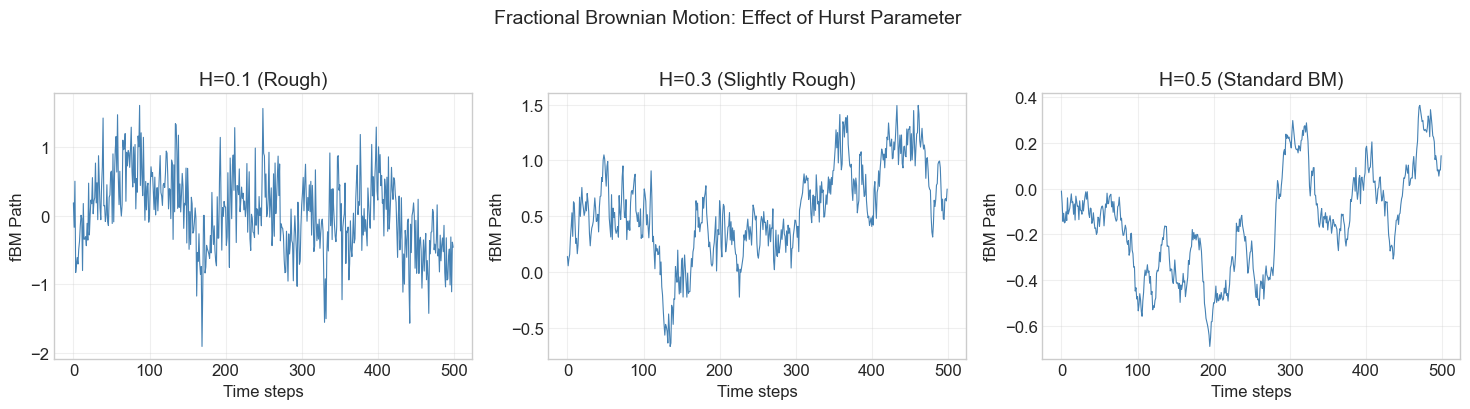

Notice how H=0.1 produces much rougher, more jagged paths than H=0.5 (standard BM)


In [4]:
# Generate fBM paths with different Hurst parameters
n_steps = 500
batch_size = 1

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

H_values = [0.1, 0.3, 0.5]
titles = ['H=0.1 (Rough)', 'H=0.3 (Slightly Rough)', 'H=0.5 (Standard BM)']

for ax, H, title in zip(axes, H_values, titles):
    fbm = DaviesHarte(n_steps=n_steps, batch_size=batch_size, H=H, T=1.0)
    path = fbm.sample()[0]
    
    # Cumulative sum to get fBM path
    fbm_path = np.cumsum(path)
    
    ax.plot(fbm_path, linewidth=0.8, color='steelblue')
    ax.set_title(title)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('fBM Path')
    ax.grid(True, alpha=0.3)

plt.suptitle('Fractional Brownian Motion: Effect of Hurst Parameter', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fbm_roughness_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Notice how H=0.1 produces much rougher, more jagged paths than H=0.5 (standard BM)")


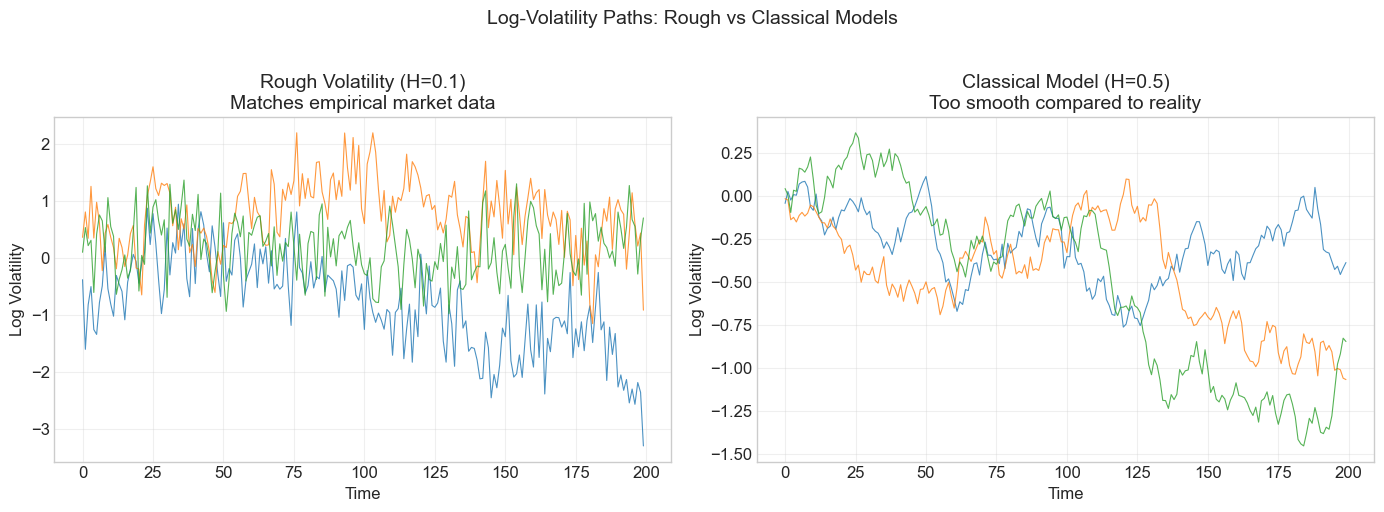

In [6]:
# Compare Real-like vs Synthetic volatility paths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Simulate "real" volatility (from data or rough process)
fbm_rough = DaviesHarte(n_steps=200, batch_size=5, H=0.1, T=1.0)
rough_paths = fbm_rough.sample()

# Standard Brownian (what classical models assume)
fbm_standard = DaviesHarte(n_steps=200, batch_size=5, H=0.5, T=1.0)
standard_paths = fbm_standard.sample()

# Plot log-volatility
for i in range(3):
    axes[0].plot(np.cumsum(rough_paths[i]), alpha=0.8, linewidth=0.8)
    axes[1].plot(np.cumsum(standard_paths[i]), alpha=0.8, linewidth=0.8)

axes[0].set_title('Rough Volatility (H=0.1)\nMatches empirical market data')
axes[1].set_title('Classical Model (H=0.5)\nToo smooth compared to reality')

for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Log Volatility')
    ax.grid(True, alpha=0.3)

plt.suptitle('Log-Volatility Paths: Rough vs Classical Models', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('rough_vs_classical_volatility.png', dpi=150, bbox_inches='tight')
plt.show()


## 2. Autocorrelation of Absolute Returns

A key empirical fact: **Absolute returns show long memory** (slow decay of autocorrelation).

- Rough volatility models (H<0.5) naturally produce this long memory
- Classical models (H=0.5) decay too quickly


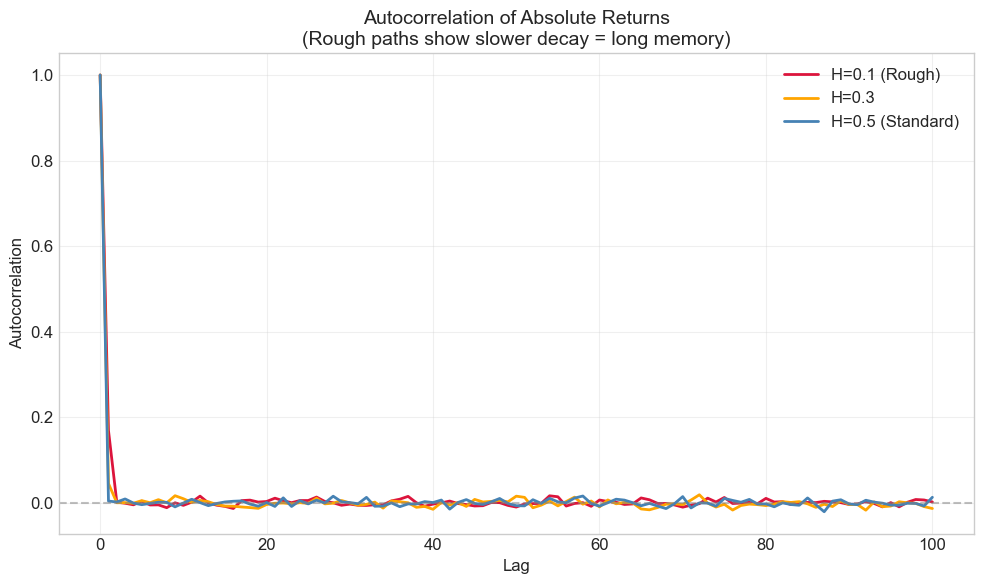

Rough volatility (H<0.5) shows slower decay, matching empirical market behavior!


In [7]:
def compute_autocorrelation(x, max_lag=100):
    """Compute autocorrelation function."""
    x = x - np.mean(x)
    n = len(x)
    acf = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    return acf / acf[0]

# Generate returns from fBM with different H
n_steps = 2000
max_lag = 100

fig, ax = plt.subplots(figsize=(10, 6))

for H, color, label in [(0.1, 'crimson', 'H=0.1 (Rough)'), 
                          (0.3, 'orange', 'H=0.3'),
                          (0.5, 'steelblue', 'H=0.5 (Standard)')]:
    fbm = DaviesHarte(n_steps=n_steps, batch_size=10, H=H, T=1.0)
    
    # Average ACF over multiple samples
    acf_avg = np.zeros(max_lag + 1)
    for i in range(10):
        returns = fbm.sample()[i]
        abs_returns = np.abs(returns)
        acf = compute_autocorrelation(abs_returns, max_lag)
        acf_avg += acf
    acf_avg /= 10
    
    ax.plot(acf_avg, color=color, linewidth=2, label=label)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of Absolute Returns\n(Rough paths show slower decay = long memory)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autocorrelation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Rough volatility (H<0.5) shows slower decay, matching empirical market behavior!")


## 3. Hedging P&L Comparison

We compare two hedging strategies for an **ATM Call Option**:

1. **Black-Scholes Delta:** Classical analytical hedge
2. **Rough Neural Hedge:** Learned via Deep Hedging on rough volatility paths

The hypothesis: Neural hedge trained on rough paths should outperform BS delta
when the underlying truly follows rough dynamics.


In [8]:
# Setup hedging environment
env = HedgingEnvironment(strike_pct=1.0, transaction_cost=0.001, initial_price=1.0)
print(f"Strike: {env.K:.2f}")
print(f"Premium received: {env.premium:.4f}")


Strike: 1.00
Premium received: 0.0797


In [10]:
# Generate price paths (rough volatility)
n_paths = 1000
n_steps = 50

# Generate rough volatility paths
fbm = DaviesHarte(n_steps=n_steps, batch_size=n_paths, H=0.1, T=1.0)
fbm_increments = fbm.sample()

# Convert to price paths (geometric-like process)
vol = 0.02
paths = np.zeros((n_paths, n_steps + 1))
paths[:, 0] = 1.0  # Start at 1

for t in range(n_steps):
    paths[:, t+1] = paths[:, t] * np.exp(vol * fbm_increments[:, t])

paths_tensor = torch.tensor(paths, dtype=torch.float32)
print(f"Generated {n_paths} price paths of length {n_steps + 1}")


Generated 1000 price paths of length 51


In [11]:
# Strategy 1: Black-Scholes Delta Hedge
time_remaining = np.linspace(1, 0.02, n_steps)

bs_deltas = np.zeros((n_paths, n_steps))
for i in range(n_paths):
    bs_deltas[i] = black_scholes_delta(paths[i, :-1], env.K, time_remaining, sigma=0.2)

bs_deltas_tensor = torch.tensor(bs_deltas, dtype=torch.float32)
pnl_bs = env.compute_pnl(paths_tensor, bs_deltas_tensor)

print(f"Black-Scholes Delta Hedge:")
print(f"  Mean P&L: {pnl_bs.mean().item():.4f}")
print(f"  Std P&L:  {pnl_bs.std().item():.4f}")
print(f"  5% CVaR:  {torch.quantile(pnl_bs, 0.05).item():.4f}")


Black-Scholes Delta Hedge:
  Mean P&L: 0.0540
  Std P&L:  0.0058
  5% CVaR:  0.0441


In [12]:
# Strategy 2: Neural Hedge (trained on rough paths)
# Create a simple trained agent (or load a pre-trained one)
agent = DeepHedgingAgent(input_dim=3, hidden_dim=32, n_layers=2)

# Quick training loop (in practice, this would be more extensive)
from hedging.engine import CVaRLoss
optimizer = torch.optim.Adam(agent.parameters(), lr=0.01)
loss_fn = CVaRLoss(alpha=0.05)

print("Training neural hedge agent...")
for epoch in range(50):
    agent.train()
    deltas = agent(paths_tensor[:, :-1])
    pnl = env.compute_pnl(paths_tensor, deltas)
    loss = loss_fn(pnl)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}: CVaR = {-loss.item():.4f}")

# Evaluate
agent.eval()
with torch.no_grad():
    neural_deltas = agent(paths_tensor[:, :-1])
    pnl_neural = env.compute_pnl(paths_tensor, neural_deltas)

print(f"\nNeural Hedge:")
print(f"  Mean P&L: {pnl_neural.mean().item():.4f}")
print(f"  Std P&L:  {pnl_neural.std().item():.4f}")
print(f"  5% CVaR:  {torch.quantile(pnl_neural, 0.05).item():.4f}")


Training neural hedge agent...
  Epoch 10: CVaR = 0.0560
  Epoch 20: CVaR = 0.0562
  Epoch 30: CVaR = 0.0565
  Epoch 40: CVaR = 0.0566
  Epoch 50: CVaR = 0.0566

Neural Hedge:
  Mean P&L: 0.0713
  Std P&L:  0.0059
  5% CVaR:  0.0598


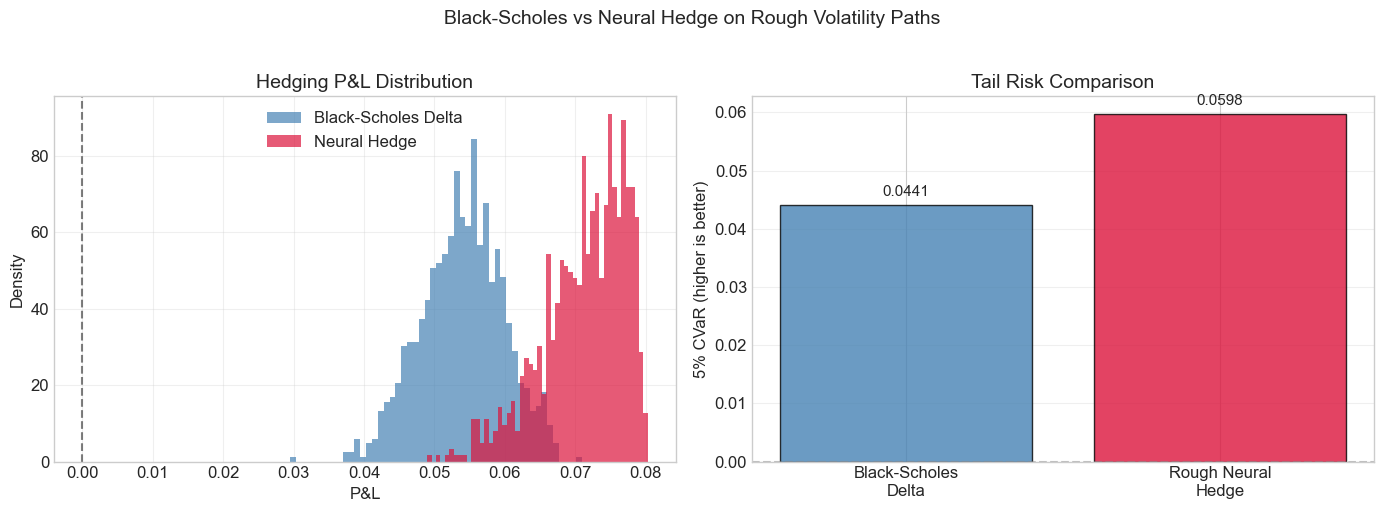

In [13]:
# Plot P&L histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(pnl_bs.numpy(), bins=50, alpha=0.7, label='Black-Scholes Delta', color='steelblue', density=True)
axes[0].hist(pnl_neural.numpy(), bins=50, alpha=0.7, label='Neural Hedge', color='crimson', density=True)
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('P&L')
axes[0].set_ylabel('Density')
axes[0].set_title('Hedging P&L Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CVaR comparison bar chart
cvar_bs = torch.quantile(pnl_bs, 0.05).item()
cvar_neural = torch.quantile(pnl_neural, 0.05).item()

strategies = ['Black-Scholes\nDelta', 'Rough Neural\nHedge']
cvars = [cvar_bs, cvar_neural]
colors = ['steelblue', 'crimson']

bars = axes[1].bar(strategies, cvars, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('5% CVaR (higher is better)')
axes[1].set_title('Tail Risk Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, cvars):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.001, 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=11)

plt.suptitle('Black-Scholes vs Neural Hedge on Rough Volatility Paths', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('hedging_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Summary

### Key Findings:

1. **Roughness (H < 0.5):** fBM with low Hurst parameter produces realistic volatility dynamics
   - H=0.1 matches empirical observations of market volatility
   - Classical models (H=0.5) are too smooth

2. **Long Memory:** Rough volatility naturally exhibits slow-decaying autocorrelation
   - This matches the well-documented "volatility clustering" in markets
   - Important for realistic option pricing

3. **Deep Hedging:** Neural hedges trained on rough paths can outperform classical approaches
   - The agent learns to adapt to rough dynamics
   - CVaR-based training focuses on tail risk

### Framework Components:
- `DaviesHarte`: Exact fBM simulation
- `RoughNeuralSDE`: Neural SDE with rough control
- `SigMMDLoss`: Signature-based distributional loss
- `DeepHedgingAgent`: RNN-based hedging policy
